<a href="https://colab.research.google.com/github/rbdus0715/Machine-Learning/blob/main/study/torch/6.auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. 이미지에 노이즈 추가**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 이미지에 가우스 노이즈를 추가하는 함수
def gaussian_noise(x, scale=0.8):

    gaussian_data_x = x + np.random.normal(
        loc=0,
        scale=scale,
        size=x.shape
    )

    # 이미지의 픽셀값을 0과 1 사이로 정규화
    gaussian_data_x = np.clip(
        gaussian_data_x, 0, 1
    )

    gaussian_data_x = torch.tensor(gaussian_data_x)
    gaussian_data_x = gaussian_data_x.type(torch.FloatTensor)
    return gaussian_data_x

In [2]:
training_data = MNIST(
    root='./',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = MNIST(
    root='./',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 114135266.84it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45216757.68it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28055102.60it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8655396.99it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



<ipython-input-1-4a17804700fa>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


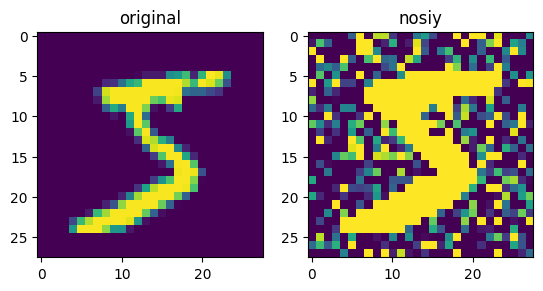

In [3]:
img = training_data.data[0]
gaussian = gaussian_noise(img)

plt.subplot(1, 2, 1)
plt.title("original")
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title("nosiy")
plt.imshow(gaussian)

## **2. 데이터셋**

In [4]:
from torch.utils.data.dataset import Dataset


class Denoising(Dataset):
   def __init__(self):
       self.mnist = MNIST(
           root="./",
           train=True,
           download=True,
           transform=ToTensor())
       self.data = []

       for i in range(len(self.mnist)):
           noisy_input = gaussian_noise(self.mnist.data[i])
           input_tensor = torch.tensor(noisy_input)
           self.data.append(torch.unsqueeze(input_tensor, dim=0))

   def __len__(self):
       return len(self.data)

   def __getitem__(self, i):
       data = self.data[i]
       label = self.mnist.data[i]/255
       return data, label

## **3. 모델 정의하기**

In [5]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            hidden_dim,
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            hidden_dim,
            out_channels,
            kernel_size=3,
            padding=1
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

In [6]:
class Encoder(nn.Module):
   def __init__(self):
       super(Encoder, self).__init__()

       self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
       self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)

       self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

   def forward(self, x):
       x = self.conv1(x)
       x = self.pool(x)
       x = self.conv2(x)
       x = self.pool(x)

       return x

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim=8)
        self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)
        return x

In [11]:
# 인코더 + 디코더
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x)
        return x

## **4. 훈련**

In [12]:
import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

trainset = Denoising()  # 학습에 이용할 데이터셋
train_loader = DataLoader(trainset, batch_size=32)  # 한 번에 이미지 32장 사용

model = CAE().to(device)  # 디노이징에 사용할 오토인코더 모델


# 학습률과 최적화를 정의
lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)

for epoch in range(20):
   iterator = tqdm.tqdm(train_loader)

   for data, label in iterator:
       optim.zero_grad()
       pred = model(data.to(device))

       loss = nn.MSELoss()(torch.squeeze(pred), label.to(device))  # 손실의 계산
       loss.backward()  # 오차 역전파
       optim.step()  # 최적화
       iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./CAE.pth")  # 모델의 가중치 저장

<ipython-input-1-4a17804700fa>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)
<ipython-input-4-e95301cf6230>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(noisy_input)
epoch20 loss:0.007918771356344223: 100%|██████████| 1875/1875 [00:15<00:00, 119.95it/s]


<ipython-input-1-4a17804700fa>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x)


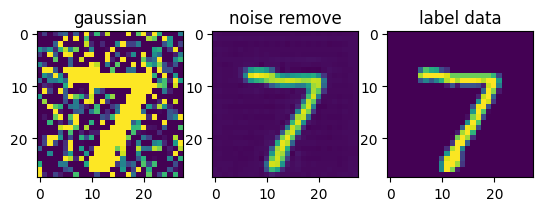

In [13]:
model.cpu()

with torch.no_grad():
    model.load_state_dict(torch.load("./CAE.pth", map_location=device))

    img = test_data.data[0]
    gaussian = gaussian_noise(img)
    input = torch.unsqueeze(gaussian, dim=0) # 이미지 + 가우스 잡음
    input.type(torch.FloatTensor)
    input.to(device)
    input = torch.unsqueeze(input, dim=0) # 배치 크기 1을 위한 배치 차원 추가

    plt.subplot(1, 3, 1)
    plt.title("gaussian")
    plt.imshow(torch.squeeze(gaussian))
    plt.subplot(1, 3, 2)
    plt.title("noise remove")
    plt.imshow(torch.squeeze(model(input)))
    plt.subplot(1, 3, 3)
    plt.title("label data")
    plt.imshow(torch.squeeze(img))
    plt.show()